In [6]:
# --- about
# this file starts with notebook data3 and adds legends to its plots

# notebooks left to do:
# bootstrapping
# kfold
# per spectrum plots

In [7]:
# --- set up environment

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.artist as art
from sklearn.decomposition import FastICA

# for Set working folder, etc.
import os
import os.path

# for sampling 
import random

# test code
# print(os.getcwd())

In [8]:
# --- etl spectrum files

# turn files into lists and cut off first line
# put into database "spectra"
# turn deleted points (flagged as -1.23e+34) into 0's
# label spectra with datafile titles


# init spectra and class databases
datafolder = "C:/Users/Bonita/Documents/GitHub/spectra-analysis/data/data3"
num_samples = len([name for name in os.listdir(datafolder) if \
                   os.path.isfile(os.path.join(datafolder,name))])
# test code 
print(num_samples)

spectrum_len = 480                                 # 480 >= the BECK spectrometer spectrum length
spectra = np.zeros((num_samples,spectrum_len))
spectrum_names = ["" for x in range(num_samples)]

y = np.zeros((num_samples, 1))

# fill databases
i = 0

# find spectra folder
os.chdir(datafolder)

# etl the data
# label data for plotting legend
for filename in os.listdir(datafolder):
    file_object  = open(filename, 'r').readlines()
    # strip off header, add to matrix 'spectra'
    spectra[i,:] = file_object[1:]                  
    
    # label spectrum class, based on header
    # actinolite: 0, alunite: 1, chlorite: 2
    file_header = file_object[0]             
                                        
    
    spectrum_names[i] = file_header
    
    # testcode
    # print(material_name)
    
    if file_header.find('Actinolite',)!= -1: #if material name contains actinolite
        y[i,0] = 0
    elif file_header.find('Alun',)!= -1:
        y[i,0] = 1
    else:                                       #chlorite
        y[i,0] = 2         
               
    # turn deleted points into 0
    for j in range(spectrum_len):  
        if spectra[i,j] <0:
            spectra[i,j]=0                          
    i+=1

# test code
# print(y[:])
# print(spectra[0:2,0])

30


In [9]:
# --- etl 

# divide up data randomly

# 80% training data 20% test for this pilot
# eventually, 60% training set, 20% validation set, 20% test set
sample_indices = list(range(0, num_samples))
train_set_size = 4*(num_samples//5)
test_set_size= num_samples-train_set_size
train_set_indices = random.sample(sample_indices,train_set_size)
test_set_indices = np.setdiff1d(sample_indices,train_set_indices)     #fixed bug: take remaining samples after making train set

# test code
# print(train_set_indices)
# print(test_set_indices)

# make train and test sets

train_set = spectra[train_set_indices, :]
train_labels = y[train_set_indices, :]
test_set = spectra[test_set_indices, :]
test_labels = y[test_set_indices, :]

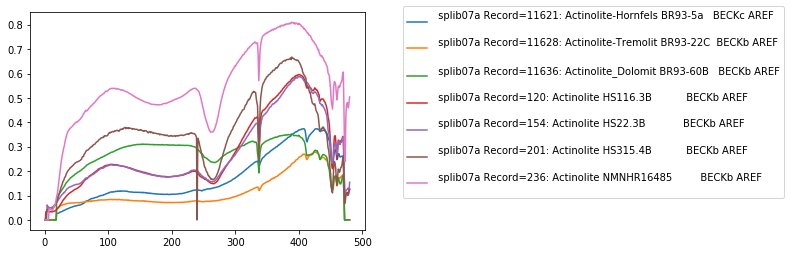

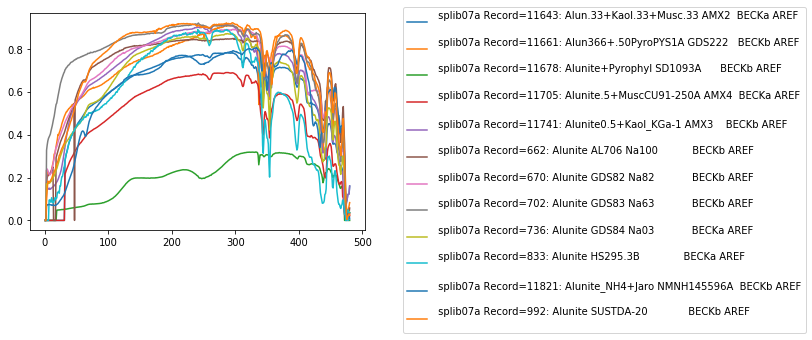

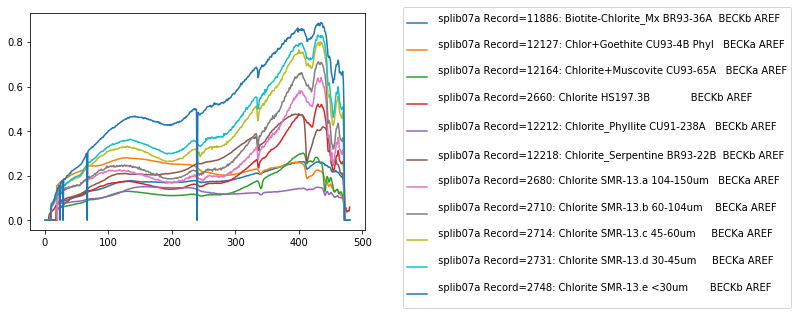

In [10]:
# --- plot the classes

# plot each class in a separate plot
# plot spectra names in legend

num0 = 0 #number of samples of class 0
num1 = 0
num2 = 0

# count the number of each class to make spectra0, spectra1, spectra2 databases
for i in range(num_samples):
    if y[i,0]== 0:
        num0 += 1
    elif y[i,0]== 1:
        num1 += 1
    elif y[i,0]== 2:
        num2 += 1

# make class-specific databases spectra0, ...1, ...2
# class-specific datasets for spectrum names too
spectra0 = np.zeros((num0,spectrum_len)) 
spectra1 = np.zeros((num1,spectrum_len)) 
spectra2 = np.zeros((num2,spectrum_len)) 

labels0 = ["" for x in range(num0)]
labels1 = ["" for x in range(num1)]
labels2 = ["" for x in range(num2)]


# make counters for each database to place spectra
i0 = 0
i1 = 0
i2 = 0

# populate class-specific databases spectra0, ...1, ...2
for i in range(num_samples):
    if y[i,0]== 0:
        spectra0[i0,:] = spectra[i,:]
        labels0[i0] = spectrum_names[i]
        i0 +=1
    elif y[i,0]== 1:
        spectra1[i1,:] = spectra[i,:]
        labels1[i1] = spectrum_names[i]
        i1 +=1
    else:
        spectra2[i2,:] = spectra[i,:]
        labels2[i2] = spectrum_names[i]
        i2 +=1

# plot each class-specific database separately
for i in range(i0):
    plt.plot(range(1, spectrum_len+1), spectra0[i,:], label = labels0[i])
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

for i in range(i1):
    plt.plot(range(1, spectrum_len+1), spectra1[i,:], label = labels1[i])
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

for i in range(i2):
    plt.plot(range(1, spectrum_len+1), spectra2[i,:], label = labels2[i])
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()  

In [11]:
# --- kfold cross validation


In [12]:
# --- Generate ICA spectra 

# ICA Parameters
num_components = 25
# Create FastICA object
ica = FastICA(n_components=num_components)

# Fit ICA model
X = spectra.T
S_ = ica.fit_transform(X)
A_ = ica.mixing_  # Estimated independent components (mixing matrix)
print(X.shape)
print(S_.shape)
print(A_.shape)

#for i in range(A_.shape[1]):
#    plt.title('Component {}'.format(i))
#    plt.plot(A_[:,i])
#    plt.figure()

(480, 30)
(480, 25)
(30, 25)


In [13]:
# --- make plain nn model

model = keras.Sequential([
    keras.layers.Dense(300, activation=tf.nn.relu),
    keras.layers.Dense(100, activation=tf.nn.relu),
    keras.layers.Dense(3, activation=tf.nn.softmax)
])

# compile
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# train
model.fit(train_set, train_labels, epochs=15)

Epoch 1/15
24/24 [==============================] - 0s 15ms/step - loss: 1.2475 - acc: 0.3333
Epoch 2/15
24/24 [==============================] - 0s 651us/step - loss: 0.9358 - acc: 0.3750
Epoch 3/15
24/24 [==============================] - 0s 0us/step - loss: 0.8986 - acc: 0.5417
Epoch 4/15
24/24 [==============================] - 0s 651us/step - loss: 0.8348 - acc: 0.6250
Epoch 5/15
24/24 [==============================] - 0s 272us/step - loss: 0.7600 - acc: 0.6250
Epoch 6/15
24/24 [==============================] - 0s 0us/step - loss: 0.7132 - acc: 0.6250
Epoch 7/15
24/24 [==============================] - 0s 652us/step - loss: 0.6859 - acc: 0.8333
Epoch 8/15
24/24 [==============================] - 0s 0us/step - loss: 0.6634 - acc: 0.6667
Epoch 9/15
24/24 [==============================] - 0s 0us/step - loss: 0.6357 - acc: 0.6667
Epoch 10/15
24/24 [==============================] - 0s 0us/step - loss: 0.6075 - acc: 0.7083
Epoch 11/15
24/24 [==============================] - 0s 651u

In [14]:
# --- test plain nn

test_loss, test_acc = model.evaluate(test_set, test_labels)

print('NN Test accuracy:', test_acc)

6/6 [==============================] - 0s 13ms/step
NN Test accuracy: 0.8333333134651184


In [15]:
# --- transform train and test set into components

train_transformed = S_[train_set_indices, :]
test_transformed = S_[test_set_indices, :]
print(train_transformed.shape)
print(test_transformed.shape)

(24, 25)
(6, 25)


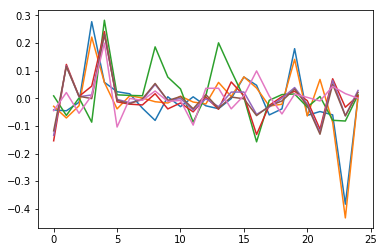

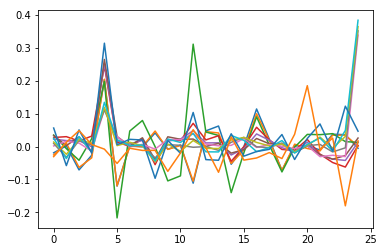

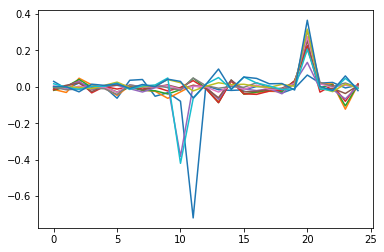

In [16]:
# --- visualize transformed spectra

# --- graph the classes

num0 = 0 #number of samples of class 0
num1 = 0
num2 = 0

# count the number of each class to make spectra0, spectra1, spectra2 databases
for i in range(num_samples):
    if y[i,0]== 0:
        num0 += 1
    elif y[i,0]== 1:
        num1 += 1
    elif y[i,0]== 2:
        num2 += 1

# make class-specific databases spectra0, ...1, ...2
icaspectra0 = np.zeros((num0, num_components)) 
icaspectra1 = np.zeros((num1, num_components)) 
icaspectra2 = np.zeros((num2, num_components)) 

# make counters for each database to place spectra
i0 = 0
i1 = 0
i2 = 0

# populate class-specific databases spectra0, ...1, ...2
for i in range(num_samples):
    if y[i,0]== 0:
        icaspectra0[i0,:] = S_[i,:]
        i0 +=1
    elif y[i,0]== 1:
        icaspectra1[i1,:] = S_[i,:]
        i1 +=1
    else:
        icaspectra2[i2,:] = S_[i,:]
        i2 +=1

# plot each class-specific database separately
for i in range(i0):
    plt.plot(icaspectra0[i,:])
plt.figure()

for i in range(i1):
    plt.plot(icaspectra1[i,:])
plt.figure()

for i in range(i2):
    plt.plot(icaspectra2[i,:])


In [17]:
# --- build NN on ICA model

model = keras.Sequential([
    keras.layers.Dense(100, activation=tf.nn.relu),
    keras.layers.Dense(3, activation=tf.nn.softmax)
])

# compile
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# train on ica
model.fit(train_transformed, train_labels, epochs=15)

Epoch 1/15
24/24 [==============================] - 0s 14ms/step - loss: 1.0933 - acc: 0.2917
Epoch 2/15
24/24 [==============================] - 0s 0us/step - loss: 1.0882 - acc: 0.2917
Epoch 3/15
24/24 [==============================] - 0s 0us/step - loss: 1.0831 - acc: 0.3333
Epoch 4/15
24/24 [==============================] - 0s 652us/step - loss: 1.0780 - acc: 0.3750
Epoch 5/15
24/24 [==============================] - 0s 0us/step - loss: 1.0729 - acc: 0.3750
Epoch 6/15
24/24 [==============================] - 0s 0us/step - loss: 1.0678 - acc: 0.5833
Epoch 7/15
24/24 [==============================] - 0s 0us/step - loss: 1.0628 - acc: 0.6250
Epoch 8/15
24/24 [==============================] - 0s 0us/step - loss: 1.0577 - acc: 0.6667
Epoch 9/15
24/24 [==============================] - 0s 651us/step - loss: 1.0526 - acc: 0.8333
Epoch 10/15
24/24 [==============================] - 0s 0us/step - loss: 1.0475 - acc: 0.8750
Epoch 11/15
24/24 [==============================] - 0s 0us/step

In [18]:
# --- test nn on ica

test_loss, test_acc = model.evaluate(test_transformed, test_labels)

print('NN Test accuracy:', test_acc)

6/6 [==============================] - 0s 22ms/step
NN Test accuracy: 1.0
